In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score
from matplotlib import pyplot as plt
import seaborn as sns
from  scipy.stats import norm, bootstrap
from statsmodels.stats.proportion import proportion_confint, confint_proportions_2indep
import pyreadr
import os

## Learning goals

To be able to conduct statistical inference for performance metrics in R, via 

- approximate confidence intervals,
- exact confidence intervals,
- and to translate such methods to method comparison.

## Preparation

Load the evaluation data for the experiments from the last exercise.

In [2]:
data_eval_ttt_2 = pyreadr.read_r(os.path.join(os.getcwd(), "data_eval_ttt_2.rds"))[None]
data_eval_ncv_2 = pyreadr.read_r(os.path.join(os.getcwd(), "data_eval_ncv_2.rds"))[None]

For the train-tune-test split, we derive a few binary variables which may be useful later. Investigate them, if needed.
If not specified otherwise, we always work on the "ttt" dataset in the following exercises.



In [3]:
actual = data_eval_ttt_2[["truth"]]
actual_01 = (actual == "suspect").astype(int).to_numpy().flatten()

pred_glmnet = data_eval_ttt_2["response_glmnet"]
pred_glmnet_01 = (pred_glmnet == "suspect").astype(int).to_numpy().flatten()
correct_glmnet_01 = (pred_glmnet_01 == actual_01).astype(int)

pred_ranger = data_eval_ttt_2["response_ranger"]
pred_ranger_01 = (pred_ranger == "suspect").astype(int).to_numpy().flatten()
correct_ranger_01 = (pred_ranger_01 == actual_01).astype(int)

## 3.1 Approximate inference for single proportions

### Task

For the train-tune-test split, calculate a 95\% (Wald) confidence interval (CI) based on the normal approximation for the classification accuracy of each model (ranger, glmnet). Don't use any packages for this purpose but rather implement the CI yourself.

- In addition, calculate a 95\% Wald interval for sensitivity, specificity of each model and the respective difference of metrics.
- What would need to be changed if only 80\% coverage was required? 

Hint: you need to calculate the required quantities (the estimated proportion, its standard error and the critical value) based on the vectors `actual_01`, `correct_glmnet_01` and `correct_ranger_01` to calculate

$$
CI = \left(\ \hat{p} - c_\alpha \hat{se}(\hat{p}),\ \hat{p} + c_\alpha \hat{se}(\hat{p}) \ \right)   

In [4]:
# You can use this codebox for your solution or add additional ones if needed

def calc_wald_ci(correct, alpha=0.05):
    phat = np.mean(correct)
    n = len(correct)
    sehat = np.sqrt(phat * (1 - phat) / n)
    cval = norm.ppf(1 - alpha / 2)
    return pd.DataFrame({
        'estimate': [phat],
        'lower': [phat - cval * sehat],
        'upper': [phat + cval * sehat]
    })

In [5]:
# You can use this codebox for your solution or add additional ones if needed

#accuracy and CI for glmnet 
print(f"accuracy and CI for glmnet: \n {calc_wald_ci(correct_glmnet_01)}")
#sensitivity and CI for glmnet
print(f"sensitivity and CI for glmnet: \n  {calc_wald_ci(correct_glmnet_01[actual_01 == 1])}")
#specificity and CI for glmnet
print(f"specificity and CI for glmnet: \n  {calc_wald_ci(correct_glmnet_01[actual_01 == 0])}")

accuracy and CI for glmnet: 
    estimate     lower     upper
0  0.932039  0.907737  0.956341
sensitivity and CI for glmnet: 
     estimate     lower     upper
0  0.777778  0.691887  0.863669
specificity and CI for glmnet: 
     estimate     lower     upper
0  0.975155  0.958154  0.992156


## 3.2 Approximate & exact inference for single proportions

### Task 

Compare the approximate results from exercise 3.1 with different (exact) alternative methods (at least those from the lecture, i.e. "wilson", "logit", "clopper-pearson") to calculate confidence intervals for for a single proportions. Also, if you find an implementation, compare the approximate CIs (method = "wald") with your own CIS from exercise 3.1. The statsmodels `proportion_confint` function should be very helpful here. I (Tom) am not sure if the logit and wald methods are implemented in statsmodels however.

In [6]:
# confidence intervals for glmnet accuracy:
proportion_confint(count = np.sum(correct_glmnet_01), nobs = len(correct_glmnet_01), alpha = 0.05, method = "wilson")


(0.9035309497534737, 0.9525645463752638)

## 3.3 Exact inference for the difference of two proportions

### Task 

Calculate an exact confidence interval with the "newcombe" method.

I suggest using the statsmodels `confint_proportions_2indep` function

Check the arguments from this function carefully and decide which of them need to be modified.

In [7]:
# You can use this codebox for your solution or add additional ones if needed

## 3.4 Inference for AUC

### Task

In this task, we want to study the ROC curve, which (to my knowledge) there isn't a simple function for in python that includes all functionality. Instead, we have to use different functions for different tasks.

- fit a ROC curve for ranger and glmnet respectively; the sklearn `roc_curve` function should serve nicely
- plot both ROC curves
- estimate the associated AUCs and calculate a 95\% CI for each one
- estimate the difference in AUCs and calculate a 95\% CI as well

Hints: 
- The AUC can be computed with the `roc_auc_score`function we used previously
- in the R exercise , the CIs are computed with the "delong" (normal approximation) and "bootstrap" methods. To my knowledge, the delong method isn't implemented in any python package. If you do find an implementation, please feel free to use it (and tell me :D) .
  Otherwise, the CIs can be calculated with the bootstrap method. For example through the scipy `bootstrap` method. 


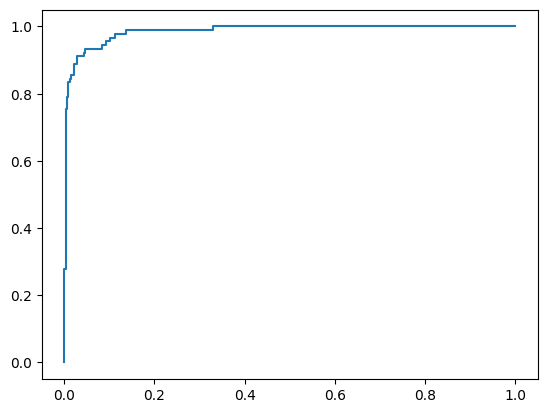

In [8]:
fpr, tpr, thresholds = roc_curve(actual_01, data_eval_ttt_2["prob.suspect_ranger"])
auc_glmnet = roc_auc_score(actual_01, pred_glmnet_01)
plt.plot(fpr, tpr, label=f'glmnet (AUC = {auc_glmnet:.2f})')

In [9]:
auc_ranger = roc_auc_score(actual_01, data_eval_ttt_2["prob.suspect_ranger"])
print(f"AUC for ranger: {auc_ranger}")
roc_CI = bootstrap([actual_01, data_eval_ttt_2["prob.suspect_ranger"]], statistic= roc_auc_score,
                    n_resamples=2000,confidence_level=0.95, paired=True)
print(f"95% CI for ranger AUC: {roc_CI.confidence_interval}")

AUC for ranger: 0.9857142857142858
95% CI for ranger AUC: ConfidenceInterval(low=np.float64(0.9696992129499359), high=np.float64(0.9933239189541714))


## 3.5 Bootstrap inference for arbitrary metrics

### Task

Utilize the scipy `bootstrap` function to calculate confidence intervals for arbitrary metrics, e.g. accuracy, sensitivity, specificity, balanced accuracy... You may restrict your attention to the ranger model.

For accuracy, you can use the `accuracy_score` function. The other metrics mentioned above arent' implemented in the libraries we've used so far. You can either find a library where they are implemented, or (which I would suggest) write a quick lambda function (`lambda x, y: ....`) that computes them. For this, you might want to use `precision_score` and `recall_score`, which are similar but different scores often used in ML that might only be a re-labeling away from being the right metric. The `pos_label` parameter of these functions might be helpful.


In [10]:
# You can use this codebox for your solution or add additional ones if needed

## 3.6 Adjusting for multiple comparisons

### Task (no code required)

How could you adjust for multiple comparisons if you wanted to do simultaneous inference on all four metrics from the last exercise? Would that be a sensible idea?

### Solution

A simple adjustment for multiple comparisons would be possible via the Bonferroni method ($\alpha^* = \alpha/m = 0.05/4=0.0125$). However, this cannot be recommended compared to choosing a priori a single primary metric (e.g. balanced accuracy) or two primary metrics (e.g. sensitivity and specificity).

## 3.7 Bootstrap inference after nested CV

Execute the following chunks and inspect/interpret the results, there is no need to modify any code.

The first chunk illustrates how data can be resampled in a "hierarchical" manner, respecting that we have observations within different folds in our evaluation data. Note that this is only a single bootstrap resample:


In [11]:
n_fold = data_eval_ncv_2['fold'].nunique()
n_obs_per_fold = round(len(data_eval_ncv_2) / n_fold)

resample = data_eval_ncv_2.groupby('fold').apply(lambda x: x.sample(n=n_obs_per_fold, replace=True)).reset_index(drop=True)
print(resample.head())

   fold  row_ids    truth response_glmnet  prob.suspect_glmnet  \
0     1      458  suspect         suspect             0.628376   
1     1     1577   normal          normal             0.000342   
2     1      971   normal          normal             0.003561   
3     1        4   normal          normal             0.063884   
4     1     1923   normal          normal             0.000120   

   prob.normal_glmnet response_ranger  prob.suspect_ranger  prob.normal_ranger  
0            0.371624         suspect             0.578167            0.421833  
1            0.999658          normal             0.000000            1.000000  
2            0.996439          normal             0.000725            0.999275  
3            0.936116          normal             0.177751            0.822249  
4            0.999880          normal             0.000000            1.000000  


C:\Users\splittgerber\AppData\Local\Temp\ipykernel_27392\2983165629.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resample = data_eval_ncv_2.groupby('fold').apply(lambda x: x.sample(n=n_obs_per_fold, replace=True)).reset_index(drop=True)




To perform the entire (naive and nested) bootstrap resampling, requires actually quite a bit of effort/code. If you are interested in the details, please check the R script "scripts/3_nested_cv_bootstrap.R". Here, we will just load the resampled data.

```{r}
resampled_cv_simple <- readRDS("data/resampled_auc_delta_cv_simple_ncv_2.rds")

resampled_cv_nested <- readRDS("data/resampled_auc_delta_cv_nested_ncv_2.rds")
```

Preview bootstrap distribution:

```{r}
head(resampled_cv_simple$delta)
head(resampled_cv_nested$delta)
```

Mean of bootstrap distribution:

```{r}
mean(resampled_cv_simple$delta)
mean(resampled_cv_nested$delta)
```


Calculate percentile confidence intervals:

```{r}
quantile(resampled_cv_simple$delta, c(0.025, 0.975))
quantile(resampled_cv_nested$delta, c(0.025, 0.975))
```


## 3.8 Continue with your own evaluation study (open-ended)

Congratulations, you made it through the prepared tasks.

You can use the remaining time of the exercise to

- specify appropriate metrics for your (upcoming) ML task,
- think about appropriate methods for data splitting,
- plan (or conduct) a sensible statistical analysis of your evaluation data.
